# Problema de Negocio 

Airbnb opera no mercado online de hospedagem, principalmente com casas de família para aluguel de temporada e atividade de turismo. No memento se observou a necessidade de prever o primeiro destino que um novo usuário vai escolher para fazer sua reserva de hospedagem.

**Causa raiz**: Por se tratar de um modelo de marketplace, onde visa conectar pessoas que oferecem um serviço, com pessoas que estão em busca dos mesmo, a necessidade vem de prever o destino para melhor aplicar a campanha de marketing. Buscando diminuir o CAC. 

## Planejamento da Entrega 

1. Resposta
- prever o destino do primeiro agendamento de hospedagem do usuário. 

2. Formato de entrega
- Json com os dados do cliente e a classificação do destino. 

3. Local de entrega 
- Api 

## Planejamento do Processo 

1. Extração e carregamento dos dados. 
2. Análise descritiva e  do dataset. 
3. Validação e tratamento de dados faltantes 
4. Feature engineering
5. Balanceamento dos dados. 
6. EAD.
7. Modelagem de dados
8. Seleção dos atributos relevantes 
9. Modelagem de algoritmo classificador e fine tunning
10. Criação Class Pipeline de dados e API Handler 
11. Deploy em produção 

## Planejamento de Entrada

1. Fonte dos dados 
- **kaggle** https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings/data
    
2. Ferramentas 
- Python 3 
- Flask 
- Sklearn 
- Jupyter Notebook 
- Heroku 

# 0.0 Import 

In [2]:
import pandas as pd 
import matplotlib.pyplot
import random
import numpy as np
import scipy.stats as stats

import sklearn.preprocessing as pp
import sklearn.model_selection as ms
from keras import models as ml
from keras import layers as l
from sklearn import metrics
from scikitplot import metrics as mt
from imblearn import combine

#visualizacao 
import seaborn as sns
from IPython.display import Image
from IPython.core.display  import HTML
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport


import os

## 0.1 Helper Functions 

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

def jupyter_settings():
    %matplotlib inline 
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    
    
    display( HTML( '<style>.container { width:80% !important; }</style>') )
    pd.options.display.max_columns = None

def cramer_v(x , y):
    conf_matrix = pd.crosstab(x,y).values
    n = conf_matrix.sum()
    r, k = conf_matrix.shape
    
    chi2 = stats.chi2_contingency(conf_matrix)[0]
    
    chi2_corr = max(0, chi2 - (k-1) * (r-1)/(n-1))
    k_corr = k-(k-1)**2 / (n-1)
    r_corr = r - (r-1)**2 / (n-1)
    
    return np.sqrt((chi2_corr/n) / (min(k-1, r-1) ) )

jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/giovane/Documentos/repo/airbnb_previsao_agendamento/airbnb_booking/lib/python3.8/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 0.2 Carregamento de dados 

In [24]:
df_user_raw = pd.read_csv('/home/giovane/Documentos/repo/airbnb_previsao_agendamento/data/raw/train_users_2.csv')
df_sessions_raw = pd.read_csv('/home/giovane/Documentos/repo/airbnb_previsao_agendamento/data/raw/sessions.csv')

# 1.0 Análise Descritiva 

In [25]:
# verificando o a dimensao dos dados (Linhas e colunas)
# Tipo dos atributos 
df_user_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       213451 non-null  object 
 1   date_account_created     213451 non-null  object 
 2   timestamp_first_active   213451 non-null  int64  
 3   date_first_booking       88908 non-null   object 
 4   gender                   213451 non-null  object 
 5   age                      125461 non-null  float64
 6   signup_method            213451 non-null  object 
 7   signup_flow              213451 non-null  int64  
 8   language                 213451 non-null  object 
 9   affiliate_channel        213451 non-null  object 
 10  affiliate_provider       213451 non-null  object 
 11  first_affiliate_tracked  207386 non-null  object 
 12  signup_app               213451 non-null  object 
 13  first_device_type        213451 non-null  object 
 14  firs

In [26]:
df_sessions_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10567737 entries, 0 to 10567736
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   user_id        object 
 1   action         object 
 2   action_type    object 
 3   action_detail  object 
 4   device_type    object 
 5   secs_elapsed   float64
dtypes: float64(1), object(5)
memory usage: 483.8+ MB


## 1.2 Dados Faltantes ( NA ) 

In [27]:
# Verificando a porcentagem de NA no dataset de usuario 
df_user_raw.isna().sum() / len(df_user_raw)

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

O df_user_raw possui 3 colunas onde apresentam dados faltantes( NA ) 
- date_first_booking 
- age 
- first_affiliate_tracked 

In [28]:
# Verificando a porcentagem de NA no dataset de sessao
df_sessions_raw.isna().sum() / len(df_sessions_raw)

user_id          0.003264
action           0.007535
action_type      0.106570
action_detail    0.106570
device_type      0.000000
secs_elapsed     0.012872
dtype: float64

O df_user_raw possui 5 colunas onde apresentam dados faltantes( NA ) 
- user_id
- action
- action_type 
- action_detail 
- secs_elapsed 

## 1.3 Preenchendo NA

### 1.3.1 Atributo date_first_booking

In [29]:
# date_first_booking 
# Verificando a procentagem de NA do date_first_booking por Classe do destino
df_user_raw[df_user_raw['date_first_booking'].isna()]['country_destination'].value_counts(normalize=True)

NDF    1.0
Name: country_destination, dtype: float64

In [30]:
# substituindo NA
date_booking_max = pd.to_datetime(df_user_raw['date_first_booking']).max().strftime('%Y-%m-%d')
df_user_raw['date_first_booking'].fillna(value=date_booking_max, inplace=True)

Complentando NA do date_first_booking  com a data maxima do dataset, ja que a falta do dado se da pelo fato do usuario nao ter feito booking

### 1.3.2 Atributo age

In [31]:
# age
# Verificando a procentagem de NA do age por Classe do destino
df_user_raw[df_user_raw['age'].isna()]['country_destination'].value_counts(normalize=True)

NDF      0.768428
US       0.156529
other    0.028617
FR       0.014888
IT       0.009081
GB       0.006251
ES       0.006171
CA       0.003989
DE       0.002387
NL       0.001818
AU       0.001171
PT       0.000671
Name: country_destination, dtype: float64

A distrubuicao de Na's aparentemente segue a proporcao de registros nas classe.

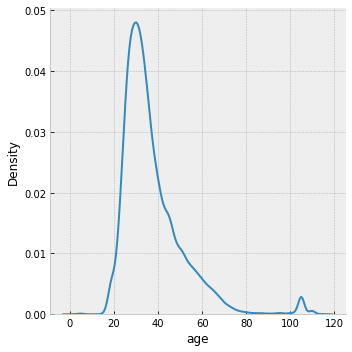

In [32]:
df_age =  df_user_raw[df_user_raw['age'] < 120] 
sns.displot(data = df_age['age'], kind = 'kde');

O atributo age segue uma distribuicao parecida com a Normal, logo, podemos substituir os NA's pela media e o desvio padrao, sem perigos de imputar um vies nos registros. 

In [33]:
df_user_raw['age'].fillna(value=df_age['age'].mean().astype( int ), inplace=True)

### 1.3.3 Atributo first_affiliate_tracked

In [34]:
df_user_raw['first_affiliate_tracked'].value_counts(normalize=True)

untracked        0.526709
linked           0.223193
omg              0.212078
tracked-other    0.029684
product          0.007503
marketing        0.000670
local ops        0.000164
Name: first_affiliate_tracked, dtype: float64

Por se tratar de uma variavel categoria, a substituicao das Na's pode acabar imputando vies no Dataset. 
Visto que os Na's representao apenas 3% do total dos dados, sera realizado o drop dos memos.

In [35]:
df_user_raw = df_user_raw[~df_user_raw['first_affiliate_tracked'].isna()]

### 1.3.4  Atributos df_sessions

In [36]:
# Drop na user_id, action, action_type, action_detail, secs_elapsed
df_sessions_raw.dropna(inplace= True)

## 1.4 Alterando Data Type

In [37]:
df_user_raw['date_account_created'] = pd.to_datetime(df_user_raw['date_account_created'])  
df_user_raw['timestamp_first_active'] = pd.to_datetime(df_user_raw['timestamp_first_active'], format='%Y%m%d%H%M%S') 
df_user_raw['date_first_booking'] = pd.to_datetime(df_user_raw['date_first_booking'])  
df_user_raw['age'] = df_user_raw['age'].astype(int)

## 1.5 Estatistica Descritiva   

In [38]:
# Separando dados em Numericos e Categoricos para o usuario
num_attributes = df_user_raw.select_dtypes(include=['int64', 'float64'])
cat_attributes = df_user_raw.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
date_attributes = df_user_raw.select_dtypes(include=['datetime64'])

# Separando dados em Numericos e Categoricos para o Sessao
num_attributes_sessions = df_sessions_raw.select_dtypes(include=['int64', 'float64'])
cat_attributes_sessions  = df_sessions_raw.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
date_attributes_sessions  = df_sessions_raw.select_dtypes(include=['datetime64'])

### 1.5.1 Atributos Numericos - Usuario  

In [39]:
# estatistica de tendencia central
num_mean = pd.DataFrame(num_attributes.mean()) 
num_median = pd.DataFrame(num_attributes.median())

# estatistica de dispersao 
num_std      = pd.DataFrame(num_attributes.std()) 
num_min      = pd.DataFrame(num_attributes.min())
num_max      = pd.DataFrame(num_attributes.max())
num_range    = pd.DataFrame(num_attributes.apply(lambda x : x.max()-x.min()))
num_skew     = pd.DataFrame(num_attributes.skew())
num_kurtosis = pd.DataFrame(num_attributes.kurtosis())

# concatenar
df_num_desc = pd.concat([num_min, num_max, num_range, num_mean, num_median, num_std,num_skew, num_kurtosis], 
                        axis=1)

df_num_desc.columns = ['Min', 'Max', 'Range', 'Mean', 'Median', 'STD', 'Skew', 'Kurtosis']

In [40]:
df_num_desc

,Min,Max,Range,Mean,Median,STD,Skew,Kurtosis
age,1,2014,2013,44.325128,37.0,118.575881,16.392840,268.929431
signup_flow,0,25,25,3.151490,0.0,7.543933,2.287158,3.567794


/home/giovane/Documentos/repo/airbnb_previsao_agendamento/airbnb_booking/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


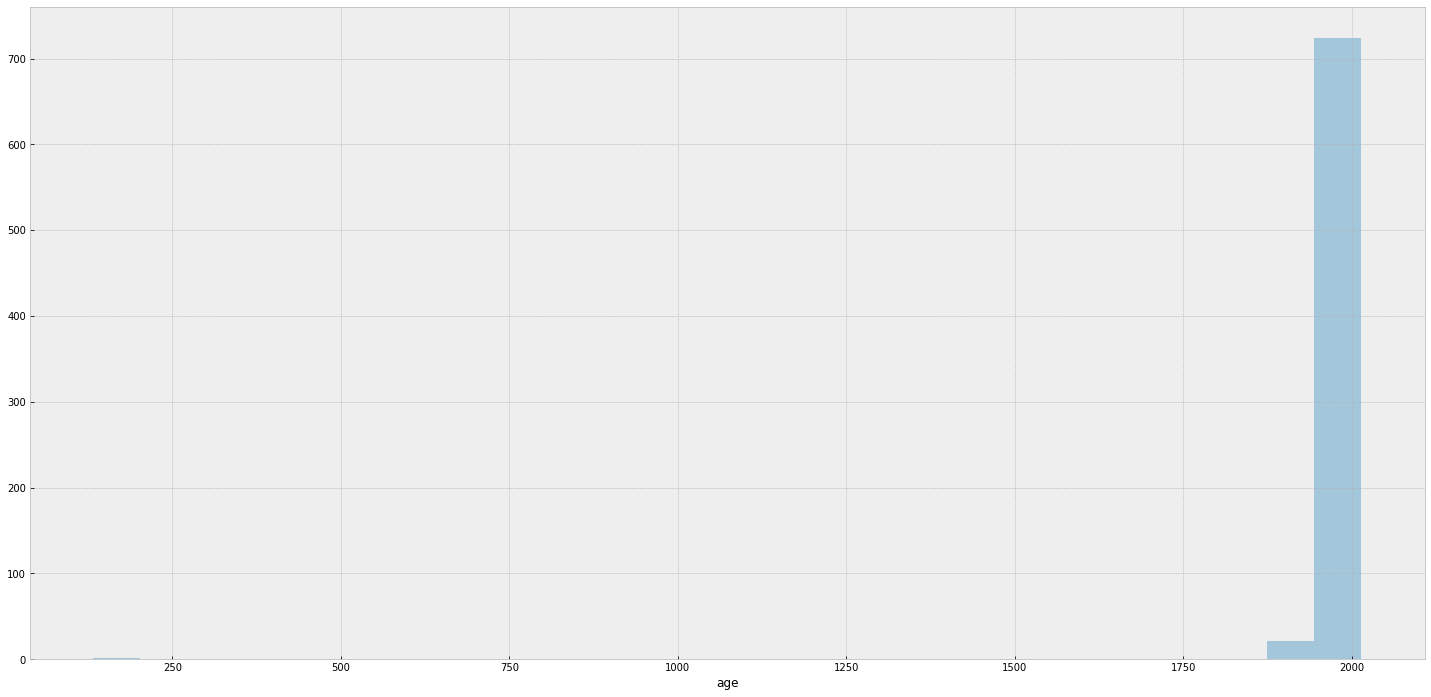

In [41]:
# filtro acima de 120 anos
aux_1 = df_user_raw[df_user_raw['age'] > 120]
sns.distplot(aux_1['age'], kde=False);

In [42]:
# proporcao de classes acina de 120 anos 
aux_1['country_destination'].value_counts(normalize=True)

NDF      0.499331
US       0.346720
other    0.060241
FR       0.024096
IT       0.017403
GB       0.013387
ES       0.012048
DE       0.009371
CA       0.008032
NL       0.006693
AU       0.001339
PT       0.001339
Name: country_destination, dtype: float64

### 1.5.2 Atributos Numericos - Sessao

In [43]:
# estatistica de tendencia central
num_mean = pd.DataFrame(num_attributes_sessions .mean()) 
num_median = pd.DataFrame(num_attributes_sessions .median())

# estatistica de dispersao 
num_std      = pd.DataFrame(num_attributes_sessions.std()) 
num_min      = pd.DataFrame(num_attributes_sessions.min())
num_max      = pd.DataFrame(num_attributes_sessions.max())
num_range    = pd.DataFrame(num_attributes_sessions.apply(lambda x : x.max()-x.min()))
num_skew     = pd.DataFrame(num_attributes_sessions.skew())
num_kurtosis = pd.DataFrame(num_attributes_sessions.kurtosis())

# concatenar
df_num_desc = pd.concat([num_min, num_max, num_range, num_mean, num_median, num_std,num_skew, num_kurtosis], 
                        axis=1)

df_num_desc.columns = ['Min', 'Max', 'Range', 'Mean', 'Median', 'STD', 'Skew', 'Kurtosis']

In [44]:
df_num_desc

,Min,Max,Range,Mean,Median,STD,Skew,Kurtosis
secs_elapsed,0.0,1799977.0,1799977.0,19961.8251,1369.0,88849.39327,11.137761,154.84312


### 1.5.3 Atributos Categoricos - Usuario

In [45]:
cat_attributes.drop('id', axis=1).describe()

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,207386,207386,207386,207386,207386,207386,207386,207386,207386,207386
unique,4,3,25,8,18,7,4,9,52,12
top,-unknown-,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,91783,148297,200415,134179,133935,109232,178334,89600,63845,120216


### 1.5.3 Atributos Categoricos - Usuario

In [46]:
cat_attributes_sessions.drop('user_id', axis=1).describe()

,action,action_type,action_detail,device_type
count,9213930,9213930,9213930,9213930
unique,347,10,155,14
top,show,view,view_search_results,Mac Desktop
freq,2178382,3545621,1770931,3019523


In [47]:
# Correlacao entre categorias 
x_columns = cat_attributes_sessions.drop('user_id', axis=1).columns.to_list()
y_columns = cat_attributes_sessions.drop('user_id', axis=1).columns.to_list()

cramer = {}

for x_col in x_columns: 
    corr = []
    for y_col in y_columns:
        corr.append(cramer_v(cat_attributes_sessions.loc[:, x_col], cat_attributes_sessions.loc[:, y_col]))
        
        cramer[x_col] = corr

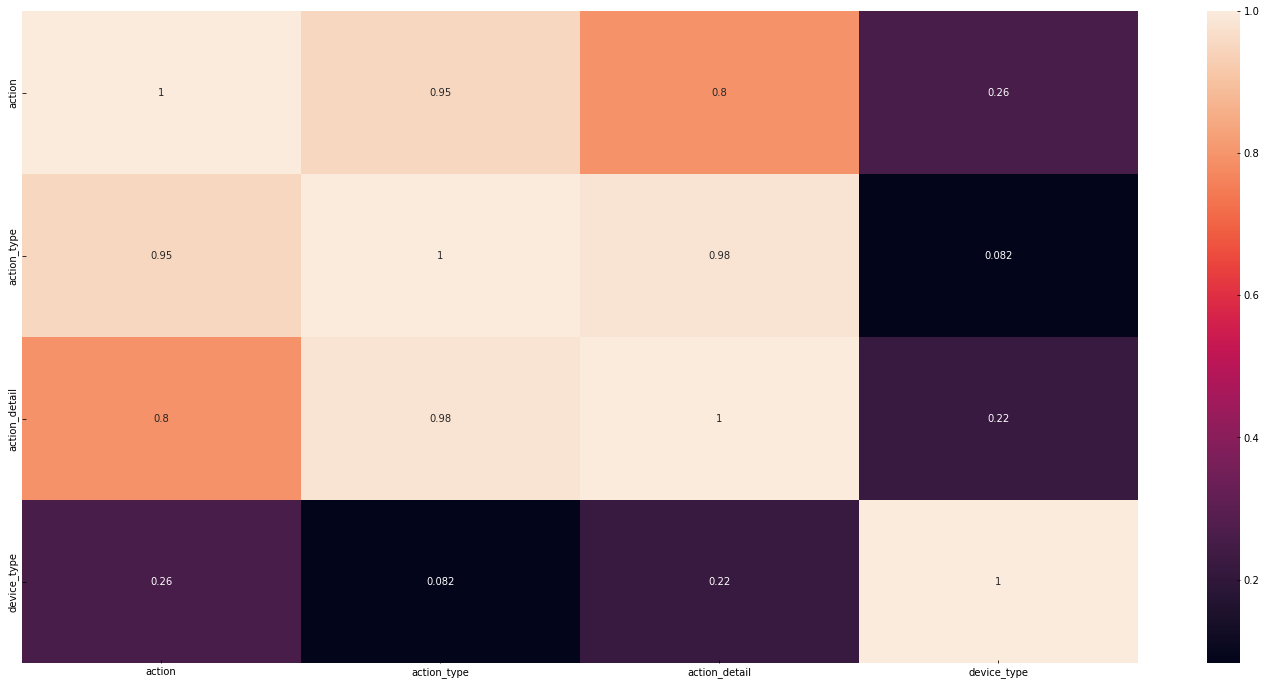

In [48]:
df_cramer_cat = pd.DataFrame(cramer)
df_cramer_cat = df_cramer_cat.set_index([x_columns])
sns.heatmap(df_cramer_cat, annot=True);

# 2.0  Feature Engineering

In [49]:
df2 = df_user_raw.copy()

## 2.1 Mapa Mental de Hipoteses

Criacao do Mapa mental de Hipotoses, levantando as analises para validacao de Hipoteses e quais atributos sera necessario devirar.

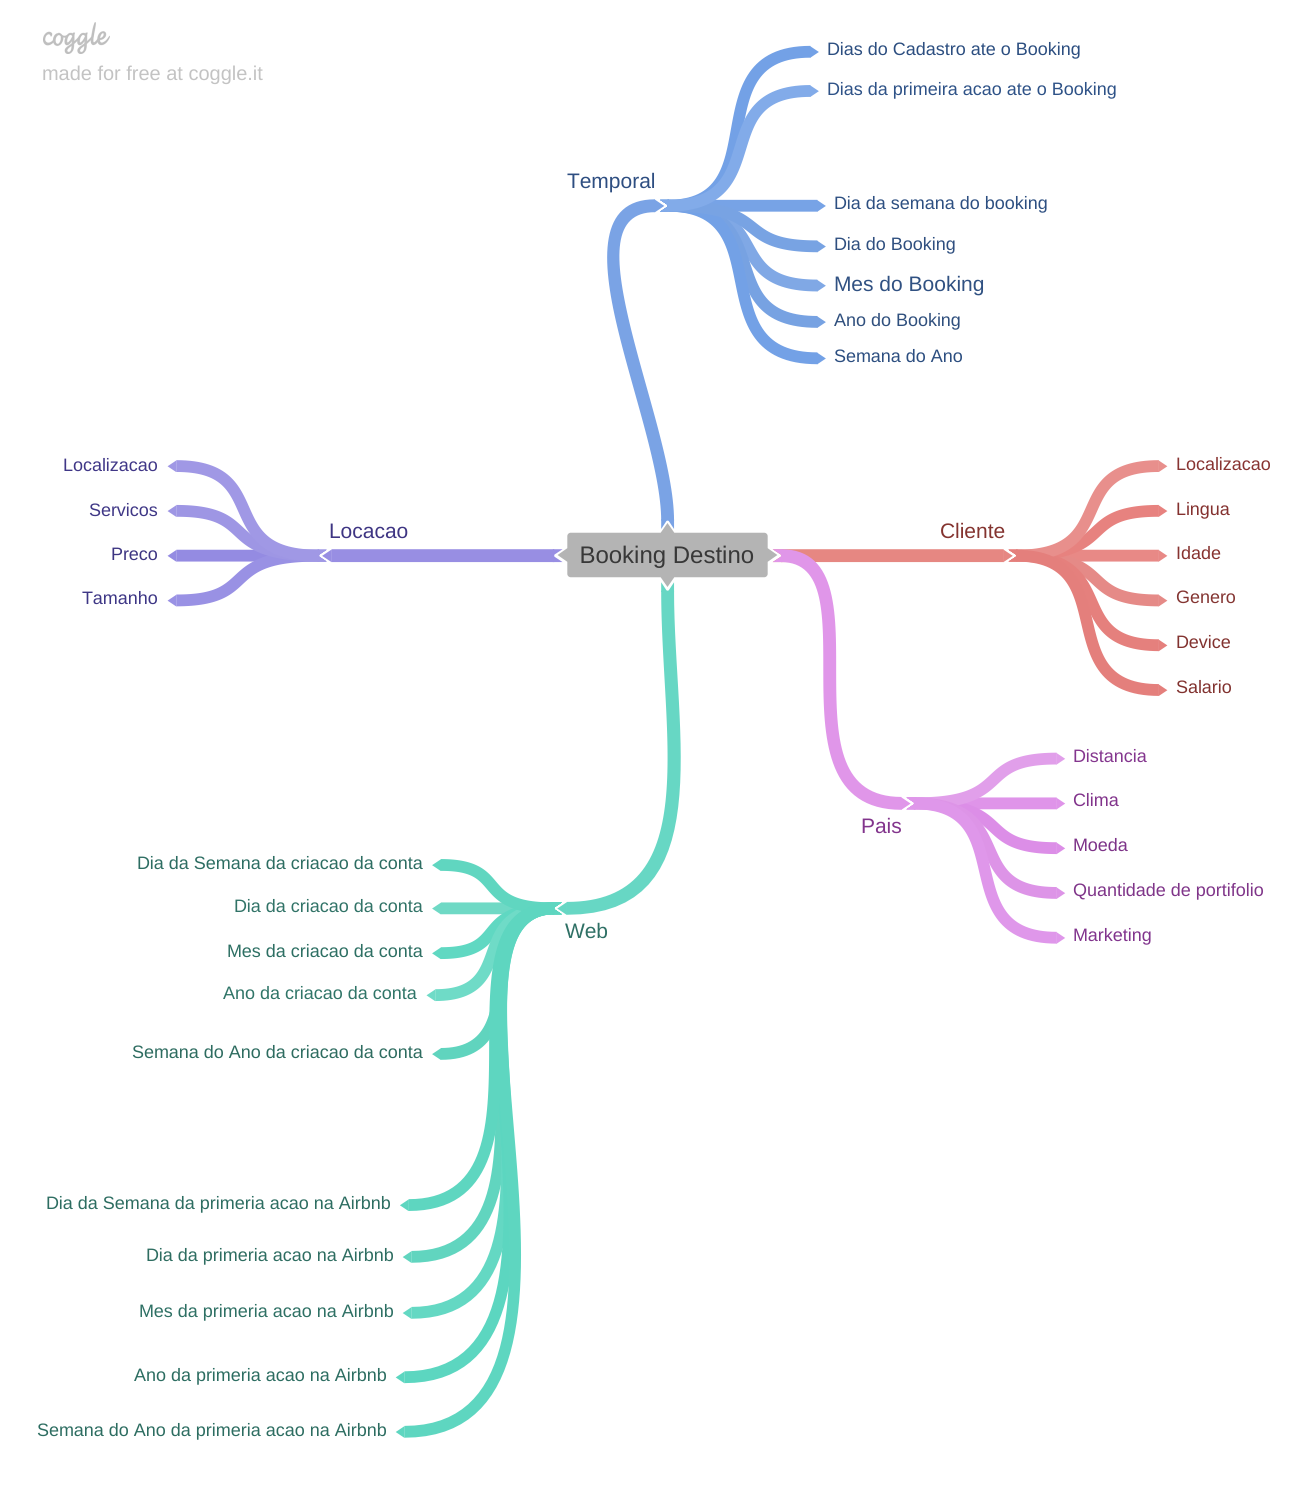

In [50]:
Image('../img/Booking_Destino.png')

## 2.2 Levantamento de Hipoteses 

**H01-** Em todos os destinos, os usuario levam 15 dias, em media para fazer a primeira reserva no Airbnb, desde sua primeira atividade. 

**H02-** Em todos os destinos, os usuarios levam 3 dias, em media, para fazer o cadastro no site. 

**H03-** O volume de reservas anual feitas durante o verao aumentaram 20% para destinos dentro dos USA. 

**H04-** Usuario do sexo feminino fazem 10% mais reservas para paises foram dos USA. 

**H05-** O canal de Marketing Google representam 40% das reservas para paises fora dos USA. 

**H06-** O destino dos USA representam mais de 20% em todos os canais. 

**H07-** A ideia media das pessoas é de 35 anos em todos os destinos. 

**H08-** A porcentagem de usuarios que usam o site na lingua ingles-americano para reservar em qualquer destino é maior que 90%?

**H09-** O numero de reservas do Airbnb é crescente ou decrescente ao longo dos anos? 

## 2.3 Lista Final de Hipoteses

## 2.4 Feature Engineering

In [51]:
# criacao de a tributos para a EDA
# dias do cadastro ate o bookin 
df2['days_account_created_booking'] = (df2['date_first_booking'] - df2['date_account_created']).apply(lambda x : x.days)

# dias da primeira acao ate o booking 
df2['days_first_active_booking'] = (df2['date_first_booking'] - pd.to_datetime(df2['timestamp_first_active'].dt.strftime('%Y-%m-%d'))).apply(lambda x : x.days)

# dias da primeira acao ate o cadastro 
df2['days_first_active_account_created'] = (df2['date_account_created'] - pd.to_datetime(df2['timestamp_first_active'].dt.strftime('%Y-%m-%d'))).apply(lambda x : x.days)

# ======= date_account_created =======
# day 
df2['day_account_created'] = df2['date_account_created'].dt.day

# month 
df2['month_account_created'] = df2['date_account_created'].dt.month

# year 
df2['year_account_created'] = df2['date_account_created'].dt.year 

# day of week 
df2['dayweek_account_created'] = df2['date_account_created'].dt.dayofweek

# week of year 
df2['weekyear_account_created'] = df2['date_account_created'].dt.weekofyear


# ======= timestamp_first_active =======
# day
df2['day_first_active'] = df2['timestamp_first_active'].dt.day

# month 
df2['month_first_active'] = df2['timestamp_first_active'].dt.month

# year 
df2['year_first_active'] = df2['timestamp_first_active'].dt.year 

# day of week 
df2['dayweek_first_active'] = df2['timestamp_first_active'].dt.dayofweek

# week of year 
df2['weekyear_first_active'] = df2['timestamp_first_active'].dt.weekofyear

# ======= date_first_booking =======
# day
df2['day_first_booking'] = df2['date_first_booking'].dt.day

# month 
df2['month_first_booking'] = df2['date_first_booking'].dt.month

# year 
df2['year_first_booking'] = df2['date_first_booking'].dt.year 

# day of week 
df2['dayweek_first_booking'] = df2['date_first_booking'].dt.dayofweek

# week of year 
df2['weekyear_first_booking'] = df2['date_first_booking'].dt.weekofyear



/tmp/ipykernel_4338/1190674166.py:25: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['weekyear_account_created'] = df2['date_account_created'].dt.weekofyear
/tmp/ipykernel_4338/1190674166.py:42: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['weekyear_first_active'] = df2['timestamp_first_active'].dt.weekofyear
/tmp/ipykernel_4338/1190674166.py:58: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['weekyear_first_booking'] = df2['date_first_booking'].dt.weekofyear


# 3.0 Filtragem de Dados

In [52]:
df3 = df2.copy()

## 3.1 Filtrangem de Linhas

In [53]:
# fintrando idade entre 15 a 120 
df3 = df3[(df3['age'] > 15) &  (df3['age'] < 120)]

# filtrando secs_elapsed maiores que 0 segundos
#df_sessions_raw = df_sessions_raw[df_sessions_raw['secs_elapsed'] > 0]

## 3.2 Filtragem de Colunas 

In [54]:
#removendo atributos que nao existem no momento da predicao 
df3.drop(['id', 'timestamp_first_active', 'date_first_booking', 'date_account_created'], axis=1, inplace=True)

# 4.0  Analise Exploratoria de Dados 

In [136]:
df4 = df3.copy()

## 4.1 Analise Univariada 

In [56]:
profilerep = ProfileReport(df4.reset_index(drop=True))
profilerep.to_file('report_univariada.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

**Atributos correlacionaveis para remocao**

days_first_active_booking  x days_account_created_booking 
- remover - days_first_active_booking 

day_first_active x day_account_created 
- remover - day_first_active 

month_first_active x month_account_created
- remover - month_first_active

year_first_active x year_account_created  
- remover - year_first_active

dayweek_first_active x dayweek_account_created 
- remover - dayweek_first_active

weekyear_first_active x  weekyear_account_created  
- remover - weekyear_first_active

weekyear_account_created x month_account_created
- remover - month_account_created

weekyear_first_booking x month_first_booking 
- remover - month_first_booking

## 4.2 Analise Bivariada - Validacao de Hipotese

### H01- Em todos os destinos, os usuario levam 15 dias, em media para fazer a primeira reserva no Airbnb, desde sua primeira atividade. 
**Verdadeiro** O usuario leva ate 5 em media para fazer sua primeira reserva desde sua primeira atividade

In [57]:
df4[['country_destination', 'days_first_active_booking']].groupby('country_destination').median()

,days_first_active_booking
country_destination,
AU,5.0
CA,3.0
DE,4.0
ES,4.0
FR,4.0
GB,4.0
IT,3.0
NDF,632.0
NL,3.0


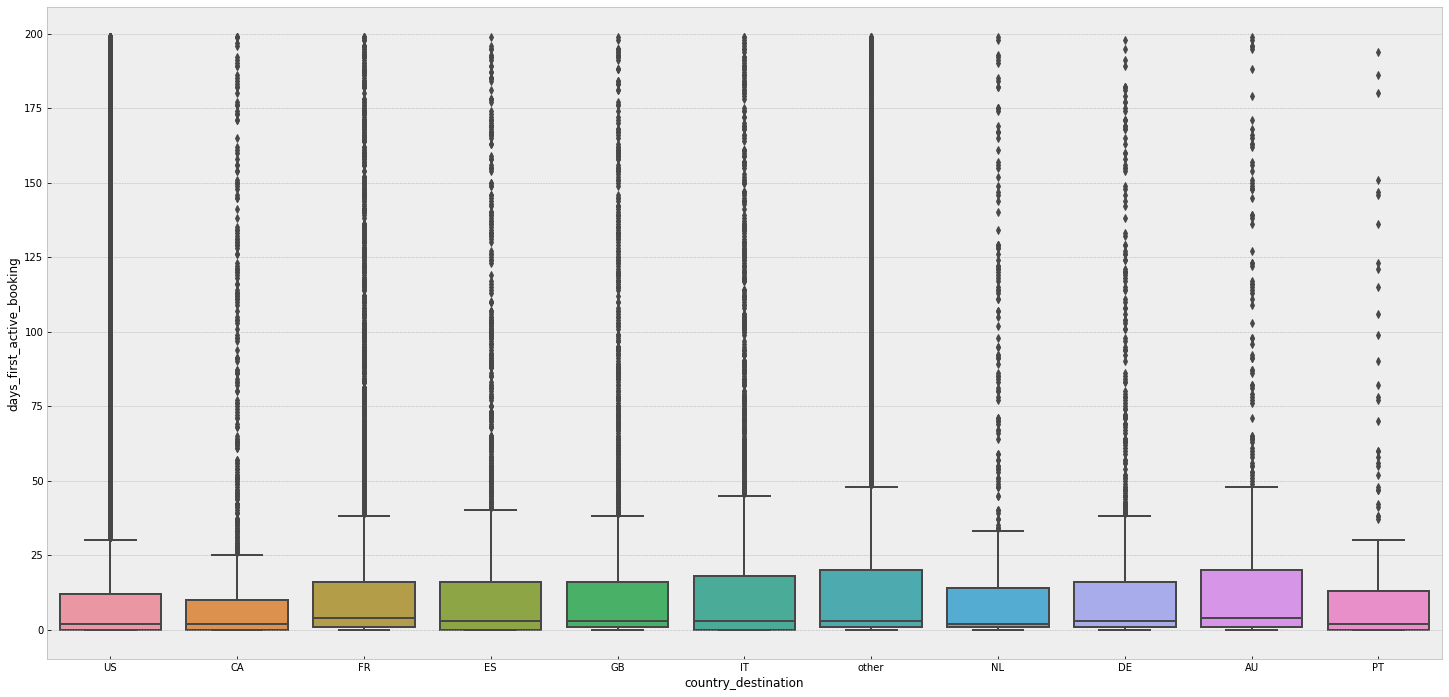

In [58]:
aux = df4[(df4['country_destination']!= 'NDF') & ( df4['days_first_active_booking']<200) ] 
sns.boxplot(x = aux['country_destination'], y = aux['days_first_active_booking']);

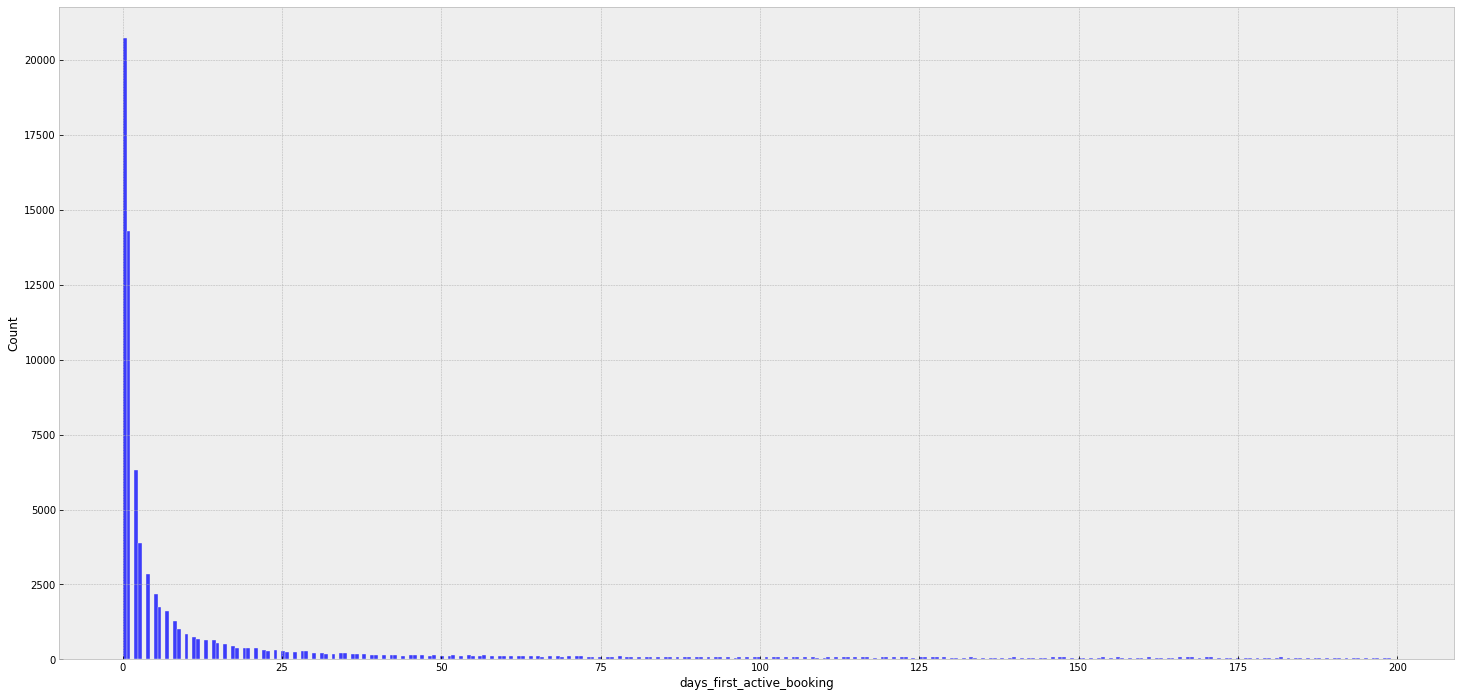

In [59]:
sns.histplot(aux['days_first_active_booking']);

### H02- Em todos os destinos, os usuarios levam 3 dias, em media, para fazer o cadastro no site. 
**Verdadeiro** Para todos os destinos o usuario leva de 0 a 2 dias para realizar o cadastro apos sua primeira interacao com o Airbnb 

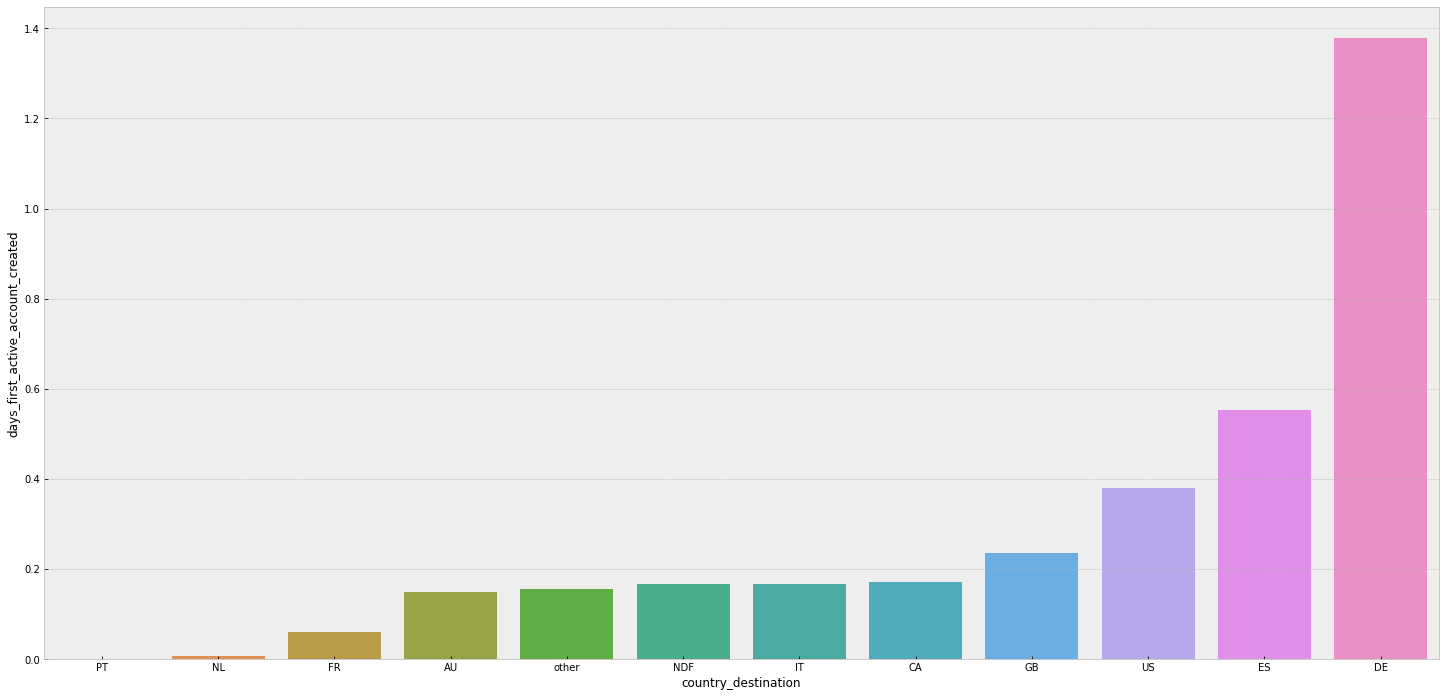

In [99]:
# Numero de dias do usuario para cadastro no site por destino. 
aux = df4[['country_destination', 'days_first_active_account_created']].groupby('country_destination').mean().reset_index()
sns.barplot(x='country_destination', y = 'days_first_active_account_created', data = aux.sort_values('days_first_active_account_created'));

### H03- O volume de reservas anual feitas durante o verao aumentaram 20% para destinos dentro dos USA. 
**Falso** Para no ultimo ano, de 2014 a 2015 tivemos um queda de 99% nas resevas para os USA

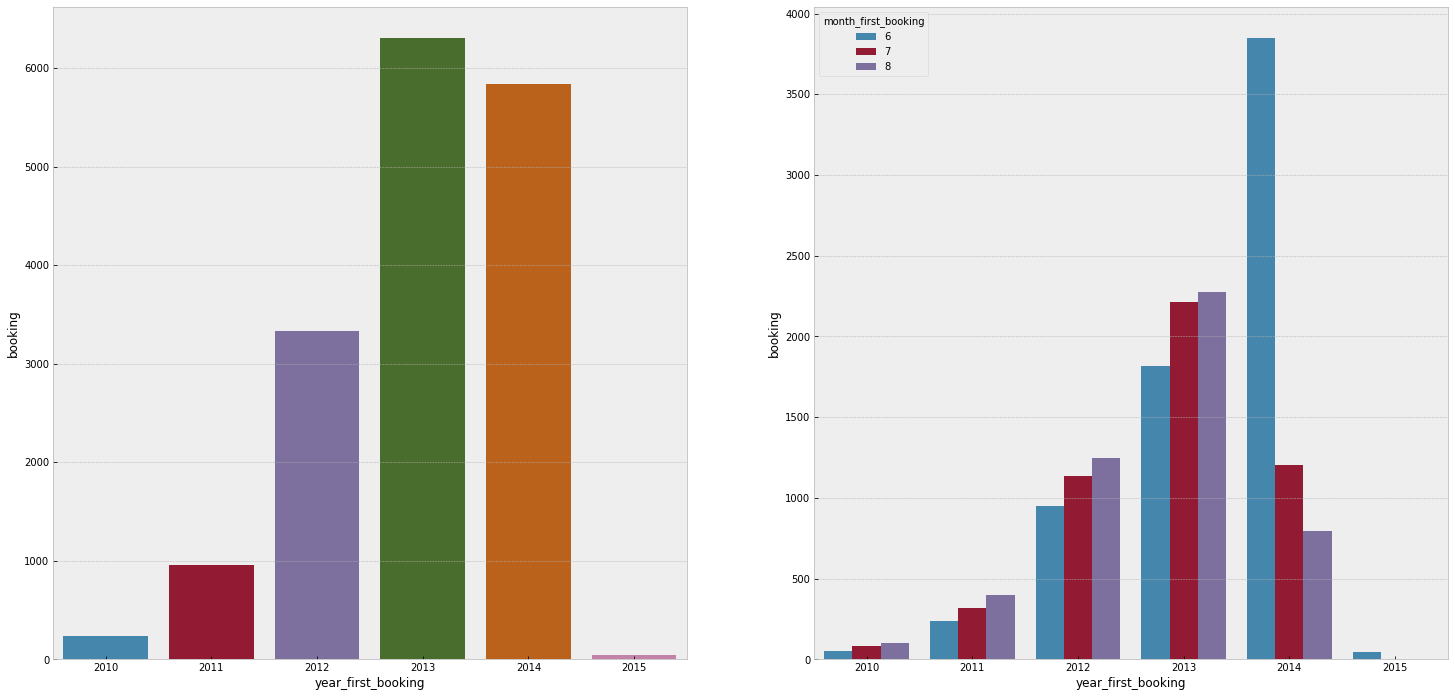

In [169]:
# filtro dos meses do verao
summer_month = [6, 7, 8]
df_filter_summer = df4[(df4['country_destination']=='US') & df4['month_first_booking'].isin(summer_month)]

# Numero de reservas ao longo dos anos
plt.subplot(1,2, 1)
aux = df_filter_summer[['country_destination', 'year_first_booking']].groupby(['year_first_booking']).size().reset_index().rename(columns = {0:'booking'})
sns.barplot(x = 'year_first_booking', y = 'booking', data = aux);

plt.subplot(1,2, 2)
# numero de reservas por mes do verao ao longo dos anos 
aux = df_filter_summer[['country_destination', 'year_first_booking', 'month_first_booking']].groupby(['year_first_booking', 'month_first_booking']).size().reset_index().rename(columns = {0:'booking'})
sns.barplot(x = 'year_first_booking', y = 'booking', hue = 'month_first_booking',data = aux);

In [167]:
# crescimento de reservas atravers dos anos em porcentagem 
aux['delta'] = aux['booking'].pct_change()*100
aux

,year_first_booking,booking,delta
0,2010,240,NaN
1,2011,953,297.083333
2,2012,3328,249.213012
3,2013,6306,89.483173
4,2014,5842,-7.358072
5,2015,44,-99.246833


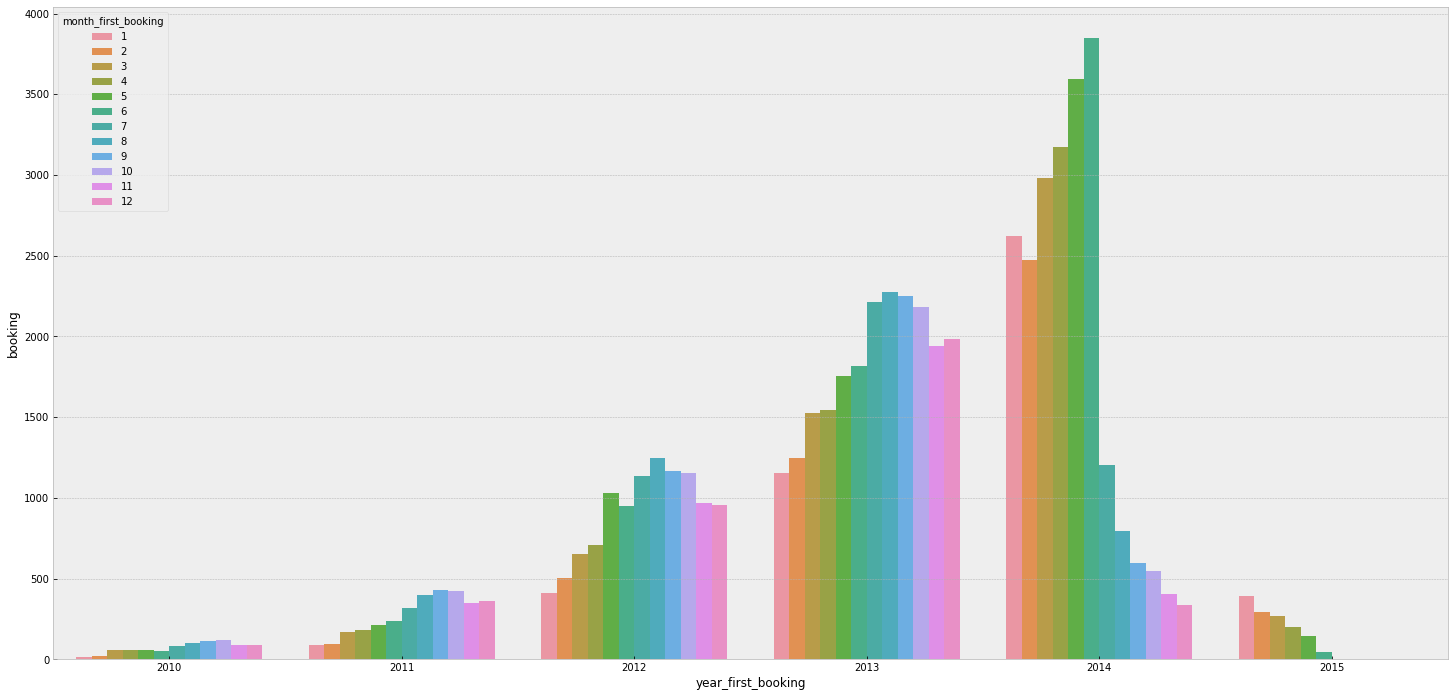

In [156]:
# numero de reservas ao longo dos meses, no periodo 2010 a 2015
df_filter_summer = df4[df4['country_destination']=='US']
aux = df_filter_summer[['country_destination', 'year_first_booking', 'month_first_booking']].groupby(['country_destination',  'year_first_booking', 'month_first_booking']).size().reset_index().rename(columns = {0:'booking'})

sns.barplot(x = 'year_first_booking', y = 'booking', hue = 'month_first_booking',data = aux);

Como visto no primeiro grafico, ate o ano de 2013 existia um aumento anual nas reservas par destinos US. DO mesmo modo para o ano de 2014 e 2015 é apresentada uma queda nas reserva. 

Verificando o ano de 2015 foi possivel ver que o mesmo nao possui o periodo de verao completo, podendo levar em uma interpretacao errada. Logo, no ano de 2014 apos o mes 6 se inicia a queda que se prolonga ate o ultimo mes disponivel no ano de 2015. 

### H04- Usuario do sexo feminino fazem 10% mais reservas para paises fora dos USA

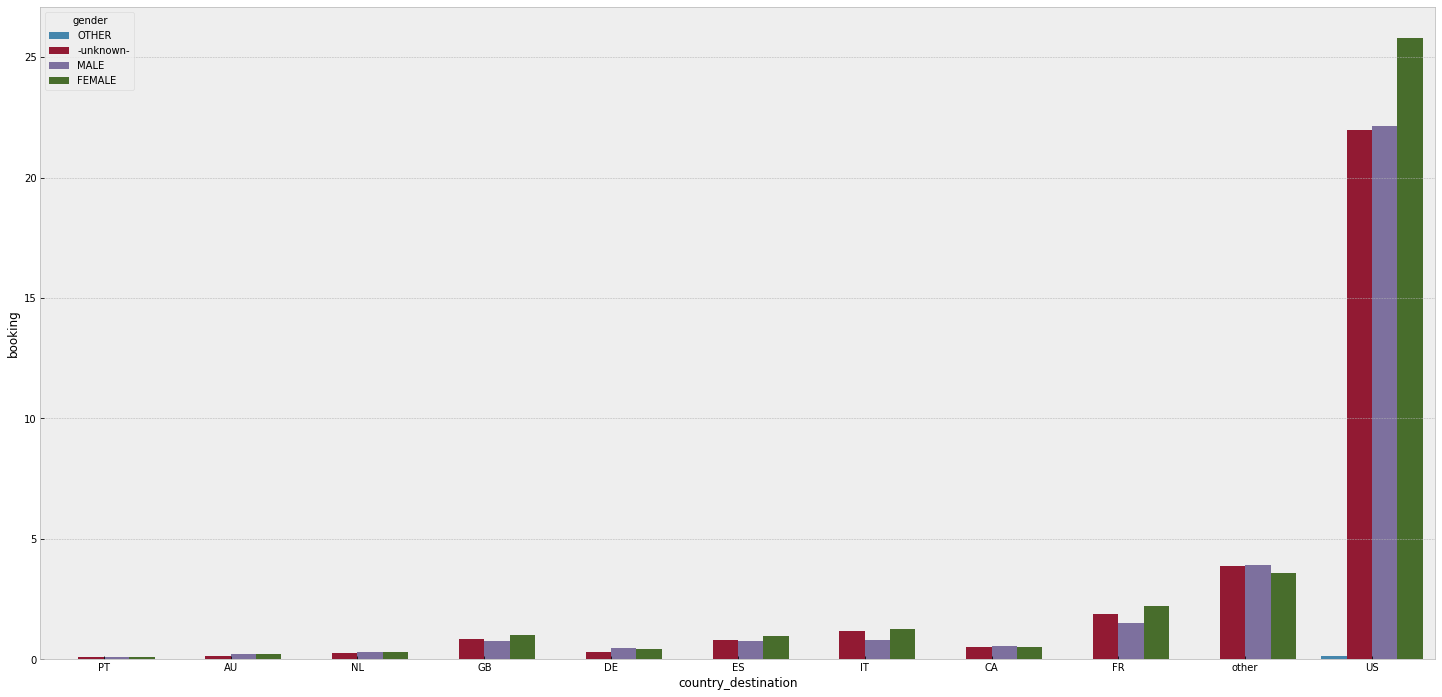

In [162]:
df_filter= df4[df4['country_destination']!= 'NDF']

aux =df_filter.groupby(['gender', 'country_destination']).size().reset_index().rename(columns=  {0:'booking'}).sort_values('booking')

aux['booking'] = aux['booking'].apply( lambda x : x/df_filter.shape[0]*100) 

aux.shape

sns.barplot(x = aux['country_destination'], y = aux['booking'], hue = aux['gender']);


### H05- O canal de Marketing Google representam 40% das reservas para paises fora dos USA. 

### H06- O destino dos USA representam mais de 20% em todos os canais. 

### H07- A ideia media das pessoas é de 35 anos em todos os destinos. 

### H08- A porcentagem de usuarios que usam o site na lingua ingles-americano para reservar em qualquer destino é maior que 90%?

### H09- O numero de reservas do Airbnb é crescente ou decrescente ao longo dos anos? 

## 4.3 Analise Multivariada 

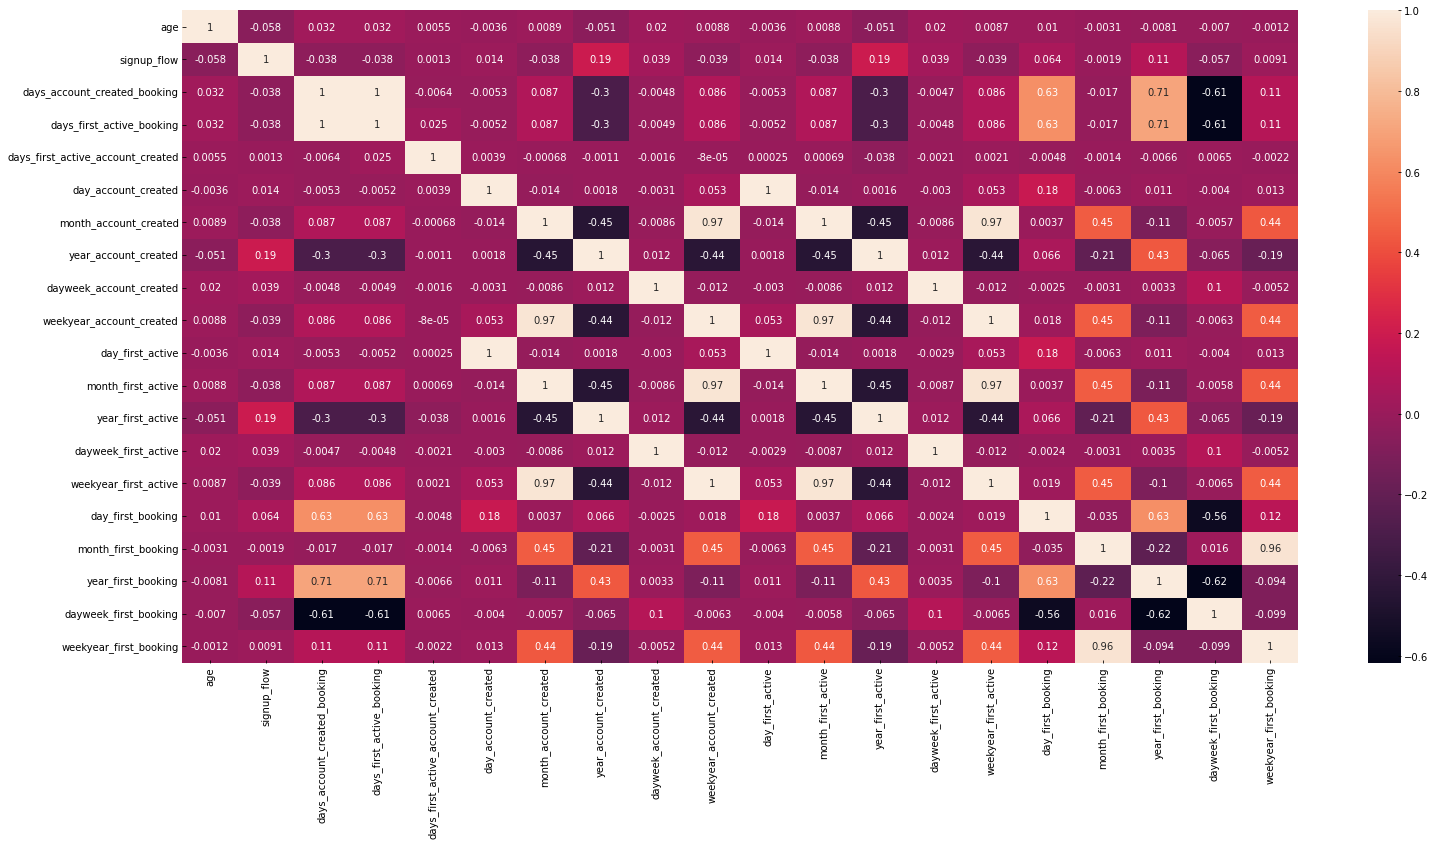

In [54]:
num_attributes = df4.select_dtypes(include=['int64', 'float64']).columns.to_list()
corr = df4[num_attributes].corr(method = 'pearson')
sns.heatmap(corr , annot = True);
plt.yticks(rotation='horizontal');

# 4.0 Balanceamento de Dados 

In [37]:
df4 = df3.copy()

In [38]:
df4['country_destination'].value_counts()

NDF      119810
US        60800
other      9935
FR         4881
IT         2776
GB         2285
ES         2203
CA         1385
DE         1033
NL          746
AU          526
PT          213
Name: country_destination, dtype: int64

##  4.1 Smote + Tomeklink

In [39]:
num_attributes = df4.select_dtypes(include=['int64', 'float64']).columns.to_list()
cat_attributes = df4.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]']).drop(['country_destination'], axis=1).columns.to_list()

encoder = pp.LabelEncoder()

df4_dummy = df4[cat_attributes].copy()
df4_dummy['gender'] = encoder.fit_transform(df4_dummy['gender'])
df4_dummy['signup_method'] = encoder.fit_transform(df4_dummy['signup_method'])
df4_dummy['language'] = encoder.fit_transform(df4_dummy['language'])
df4_dummy['affiliate_channel'] = encoder.fit_transform(df4_dummy['affiliate_channel'])
df4_dummy['affiliate_provider'] = encoder.fit_transform(df4_dummy['affiliate_provider'])
df4_dummy['first_affiliate_tracked'] = encoder.fit_transform(df4_dummy['first_affiliate_tracked'])
df4_dummy['signup_app'] = encoder.fit_transform(df4_dummy['signup_app'])
df4_dummy['first_device_type'] = encoder.fit_transform(df4_dummy['first_device_type'])
df4_dummy['first_browser'] = encoder.fit_transform(df4_dummy['first_browser'])



df4_encoded = pd.concat([df4[num_attributes], df4_dummy], axis=1)

In [40]:
ratio_balanced =  {'NDF': 119810,
                   'US':  60800,
                   'other': 6*9935,
                   'FR': 12*4881,
                   'IT': 20*2776,
                   'GB': 30*2285,
                   'ES': 30*2203,
                   'CA': 40*1385,
                   'DE': 45*1033,
                   'NL': 80*746,
                   'AU': 85*526,
                   'PT': 300*213}

In [41]:
sampler = combine.SMOTETomek(sampling_strategy=ratio_balanced ,random_state=42, n_jobs= -1)
x_sample, y_sample = sampler.fit_resample(df4_encoded, df4['country_destination'])

KeyboardInterrupt: 

In [ ]:
y_sample.value_counts()

In [ ]:
# atributos numericos 
df_balanced_num = x_sample[num_attributes]

#atributos categoricos 
df_balanced_cat = x_sample.drop(num_attributes, axis=1)

df_balanced_cat['gender'] = encoder.inverse_transform(df_balanced_cat['gender'])
df_balanced_cat['signup_method'] = encoder.inverse_transform(df_balanced_cat['signup_method'])
df_balanced_cat['language'] = encoder.inverse_transform(df_balanced_cat['language'])
df_balanced_cat['affiliate_channel'] = encoder.inverse_transform(df_balanced_cat['affiliate_channel'])
df_balanced_cat['affiliate_provider'] = encoder.inverse_transform(df_balanced_cat['affiliate_provider'])
df_balanced_cat['first_affiliate_tracked'] = encoder.inverse_transform(df_balanced_cat['first_affiliate_tracked'])
df_balanced_cat['signup_app'] = encoder.inverse_transform(df_balanced_cat['signup_app'])
df_balanced_cat['first_device_type'] = encoder.inverse_transform(df_balanced_cat['first_device_type'])
df_balanced_cat['first_browser'] = encoder.inverse_transform(df_balanced_cat['first_browser'])

#concatenando numerico e categorico 
df_balanced = pd.concat([df_balanced_num, df_balanced_cat], axis=1)
df_balanced['country_destination'] = y_sample

# 5.0 Modelagem de Dados 

In [ ]:
df5 = df_balanced.copy()

## 5.1 Encoding 

In [ ]:
df5_dummies = pd.get_dummies(df5.drop('country_destination', axis=1))
df5 = pd.concat([df5_dummies, df5['country_destination']], axis=1)

# 6.0 Selecao de Atributos  

In [1]:
df6= df5.copy()

NameError: name 'df5' is not defined

## 6.1  Selecao de Atributos Colineares

In [ ]:
['days_first_active_accouny_created', 'year_first_active', 'language', 'affiliate_provider', 'first_device_type',
'first_browser']

In [ ]:
['days_account_created_booking', '']

# 6.0 Modelagem Machine Learning 

In [ ]:
df6 = df5.copy()

## 6.1 Separar Dados Teste e Validação  

In [ ]:
x = df6.drop('country_destination', axis=1)
y = df6['country_destination'].copy()

In [ ]:
x_train, x_test, y_train, y_test = ms.train_test_split(x, y, test_size=0.2, random_state=42)

## 6.2 Modelo Baseline

In [ ]:
l_country_destination = df6['country_destination'].sort_values().unique()
country_destination_weights = df6['country_destination'].value_counts(normalize=True).sort_index().tolist()
k_num = y_test.shape[0]

# Modelo de classificacao aleatoria
yhat_random = random.choices(population=l_country_destination, k=k_num, weights= country_destination_weights )

### 6.2.1 Performance do Modelo - Baseline 

In [ ]:
# acuracia 
acuracia_random = metrics.accuracy_score(y_test, yhat_random)
print('Acuracia:{}'.format(acuracia_random))

# Acuracia balanceada 
balanced_accuracy_random = metrics.balanced_accuracy_score(y_test, yhat_random)
print('Acuracia Balanceada: {}'.format(balanced_accuracy_random))

# kappa 
kappa_random = metrics.cohen_kappa_score(y_test, yhat_random)
print('Kappa: {}'.format(kappa_random))

print(metrics.classification_report(y_test, yhat_random))

# Matriz de confusao
mt.plot_confusion_matrix(y_test, yhat_random, normalize=False, figsize=(12,12));

## 6.3 Neural Network - MLP

In [ ]:
# encode para variavel y 
encoder = pp.OneHotEncoder()
y_train_nn = encoder.fit_transform(y_train.values.reshape(-1,1)).toarray()

In [ ]:
# definicao do modelo
model = ml.Sequential()
model.add(l.Dense(128, input_dim=x_train.shape[1], activation="relu"))
model.add(l.Dense(12, activation="softmax"))

# compilando modelo 
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])

# treinamento 
model.fit(x_train, y_train_nn, epochs=100, verbose = 0)

### 6.3.1 Performance do Modelo - MLP 

In [ ]:
# predicao 
pred = model.predict(x_test)

# invertendo o encoder 
yhat_nn = encoder.inverse_transform(pred)

y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape(1,-1)[0]

In [ ]:
# acuracia 
acuracia_nn = metrics.accuracy_score(y_test_nn, yhat_nn)
print('Acuracia:{}'.format(acuracia_nn))

# Acuracia balanceada 
balanced_accuracy_nn = metrics.balanced_accuracy_score(y_test_nn, yhat_nn)
print('Acuracia Balanceada: {}'.format(balanced_accuracy_nn))

# kappa 
kappa_nn = metrics.cohen_kappa_score(y_test_nn, yhat_nn)
print('Kappa: {}'.format(kappa_nn))

print(metrics.classification_report(y_test_nn, yhat_nn))


In [ ]:
# Matriz de confusao
mt.plot_confusion_matrix(y_test_nn, yhat_nn, normalize=False, figsize=(12,12));

O modelo acabou sendo inviesado, pelo fato do dataset estar desbalanceado. Podemos ver também que a acuracia de acimade 70%, as mesma também segue sendo inviesada pelo grande número de registro com US.

### 6.3.2 Cross Validation - MLP 

In [ ]:
# gerar fold 
num_fold = 5 
kfold = ms.StratifiedKFold(n_splits= num_fold, shuffle=True, random_state=42)

l_balanced_acc =[]
l_kappa = []
i=1 

for train_ix, val_ix in kfold.split(x_train, y_train):
    print('Fold {}/{}'.format(i, num_fold))
    
    # fold 
    x_train_fold = x_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]
    
    x_val_fold = x_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]
    
    # encoder target
    encoder = pp.OneHotEncoder()
    y_train_fold_nn = encoder.fit_transform(y_train_fold.values.reshape(-1,1)).toarray()

    # definicao do modelo
    model = ml.Sequential()
    model.add(l.Dense(128, input_dim= x_train_fold.shape[1], activation="relu"))
    model.add(l.Dense(12, activation="softmax"))

    # compilando modelo 
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])

    # treinamento 
    model.fit( x_train_fold, y_train_fold_nn, epochs=100, batch_size = 42, verbose=0)

    # predicao 
    pred_nn = model.predict(x_val_fold)

    # invertendo o encoder 
    yhat_fold_nn = encoder.inverse_transform(pred_nn)

    y_val_fold_nn = y_val_fold.to_numpy()
    yhat_fold_nn = yhat_fold_nn.reshape(1,-1)[0]
    
    #metricas 
    ## Balanced Accuracy
    balanced_acc_fold = metrics.balanced_accuracy_score(y_val_fold_nn, yhat_fold_nn)
    l_balanced_acc.append(balanced_acc_fold)
    
    ##Kappa 
    kappa_fold = metrics.cohen_kappa_score(y_val_fold_nn, yhat_fold_nn)
    l_kappa.append(kappa_fold)
    
    i = i+1
    

In [ ]:
print('Balanced Accuracy: {:.4f}+/-{:.4f}'.format(np.mean(l_balanced_acc), np.std(l_balanced_acc)) )
print('Kappa: {:.4f}+/-{:.4f}'.format(np.mean(l_kappa), np.std(l_kappa)) )